# Feature Selection
## Introduction to Feature Selection methods and their implementation in Python

Feature selection can be done in multiple ways but there are broadly 3 categories of it:
1. Filter Method 
2. Wrapper Method 
3. Embedded Method

In [0]:
#importing libraries

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

%matplotlib inline

In [0]:
#Loading the dataset

x = load_boston()

df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target

X = df.drop("MEDV",1)   #Feature Matrix
y = df["MEDV"]          #Target Variable

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#Filter Method

As the name suggest, in this method, you filter and take only the subset of the relevant features. The model is built after selecting the features. The filtering here is done using correlation matrix and it is most commonly done using Pearson correlation.

Here we will first plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable MEDV. We will only select features which has correlation of above 0.5 (taking absolute value) with the output variable.

The correlation coefficient has values between -1 to 1
 — A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
 — A value closer to 1 implies stronger positive correlation
 — A value closer to -1 implies stronger negative correlation

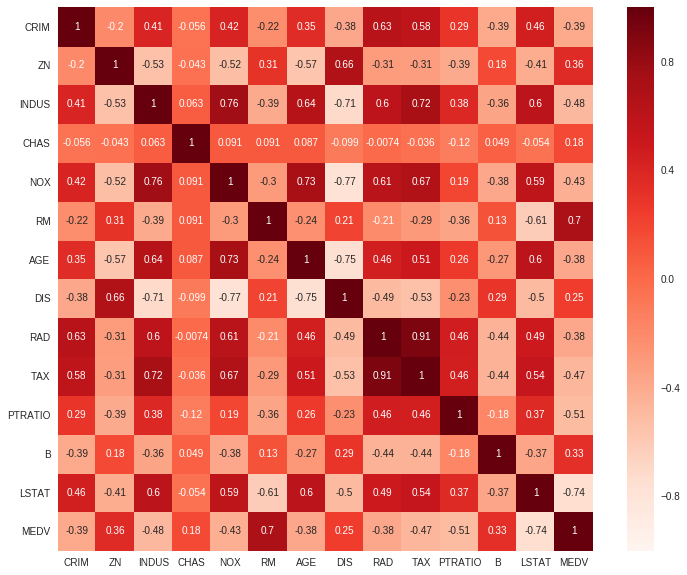

In [0]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [0]:
#Correlation with output variable

cor_target = abs(cor["MEDV"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

In [0]:
print(df[["LSTAT","PTRATIO"]].corr())
print(df[["RM","LSTAT"]].corr())

            LSTAT   PTRATIO
LSTAT    1.000000  0.374044
PTRATIO  0.374044  1.000000
             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000


RM and LSTAT are highly correlated with each other (-0.613808). Hence we would keep only one variable and drop the other. We will keep LSTAT since its correlation with MEDV is higher than that of RM.

After dropping RM, we are left with two feature, LSTAT and PTRATIO. These are the final features given by Pearson correlation.

#Wrapper Method

A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. We will discuss Backward Elimination and RFE here.

### Backward Elimination

As the name suggest, we feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

In [0]:
# We are using OLS model which stands for “Ordinary Least Squares”.
# This model is used for performing linear regression.

cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


###RFE (Recursive Feature Elimination)

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [0]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 7)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y) 

#Fitting the data to model
model.fit(X_rfe,y)

print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


Here we took LinearRegression model with 7 features and RFE gave feature ranking as above, but the selection of number ‘7’ was random. Now we need to find the optimum number of features, for which the accuracy is the highest. We do that by using loop starting with 1 feature and going up to 13. We then take the one for which the accuracy is highest.

In [0]:
#no of features
nof_list=np.arange(1,13)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(
        X,y,
        test_size = 0.3,
        random_state = 0,
    )
    
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 10
Score with 10 features: 0.663581


As seen from above code, the optimum number of features is 10. We now feed 10 as number of features to RFE and get the final set of features given by RFE method, as follows:

In [0]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 10)   

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


##Embedded Method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.



Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444
Lasso picked 10 variables and eliminated the other 3 variables


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

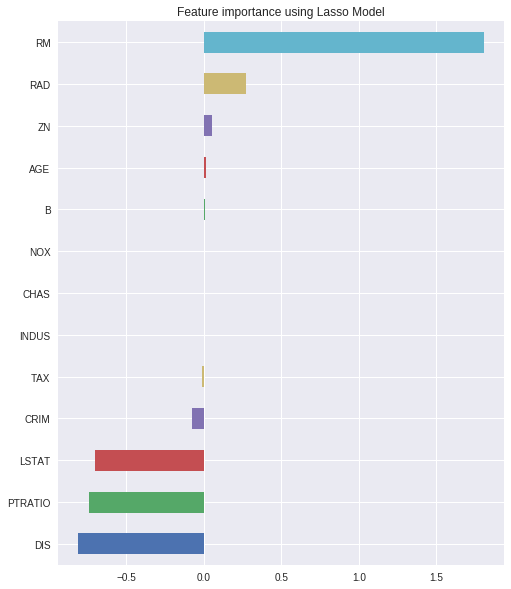

In [0]:

#Lasso linear model with iterative fitting along a regularization path.
reg = LassoCV()

reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0))
      + " variables and eliminated the other "
      +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

##Conclusion:

We saw how to select features using multiple methods for Numeric Data and compared their results. Now there arises a confusion of which method to choose in what situation. Following points will help you make this decision.

* Filter method is less accurate. It is great while doing EDA, it can also be used for checking multi co-linearity in data.
* Wrapper and Embedded methods give more accurate results but as they are computationally expensive, these method are suited when you have lesser features (~20).

